Comic Vine API analysis - Noah Matos

For my project I decided to use the ComicVine API, which is a database of most comic characters in existence. I decided that I wanted to take the top 15 characters from two publishers and figure out if there was a correlation between the amount of issues they appeared in and their popularity as a whole. I chose to focus on Image Comics, a smaller, more independent comic publishing company and pit them against Marvel Comics, arguably the biggest comic publisher in the world.

In [1]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
import numpy as np

In [2]:
cv_key = pd.read_csv('comicvine key.txt')
cv_key.keys()

Index(['API-key'], dtype='object')

In [3]:
key = cv_key['API-key'].iloc[0]



I am just going to create a few variables to hold the api base URL and structure the parameter that holds the API key.

In [4]:
api_url = 'https://comicvine.gamespot.com/api/'
key_url = 'api_key='+str(key)

In [5]:
failed_request = characters_response = requests.get(api_url + 'characters/?' + key_url + '&format=json')
failed_request.status_code

403

In [6]:
with open('comicvine_out.html', 'w') as t:
    t.write(failed_request.text)

In [16]:
char_list = ['4005-24863', '4005-3381', '4005-40550', '4005-51840', '4005-42443', '4005-5210', '4005-48901', '4005-17996', '4005-5209','4005-5195','4005-5182','4005-47906', '4005-6538', '4005-64035', '4005-17859']
responses = []
for i in char_list:
    resp = requests.get(api_url+'character/'+str(i)+'?'+key_url + '&format=json', headers = {'User-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/18.0.1 Safari/605.1.15'} )
    chj = json.loads(resp.text)
    responses.append(chj['results'])

In [17]:
print(api_url + 'character/' + str(i) + '?' + key_url)

https://comicvine.gamespot.com/api/character/4005-17859?api_key=61e513aa5ef93ccd3df87a74b91f41a6fce71448


In [18]:
ic_df = pd.DataFrame(responses)
#ic_df

I have put the Image Comic characters that I would like to focus on in their own dataframe. I did this by getting the ID's of each character manually and putting them in a list. The function that is above automatically gets the 'results' from each character's call and puts them into a dataframe.

In [19]:
ic_df['publisher'].iloc[1]

{'api_detail_url': 'https://comicvine.gamespot.com/api/publisher/4010-513/',
 'id': 513,
 'name': 'Image'}

Next, I need to make it so that that 513 code (which = image comics) reads as 'Image Comics' in the dataframe. I used chatgpt to help out below with anything that has the lambda functionaility inputted as well as this function (map_publisher_id) below. I used it because I needed to know how to isolate just the 'id' of 'publisher' and 'name' from 'powers'

In [20]:
#ic_df['powers'].iloc[0]

In [21]:
ic_df['power_names'] = ic_df['powers'].apply(lambda x: [power['name'] for power in x] if isinstance(x, list) else None)

In [22]:
ic_df['publisher_id'] = ic_df['publisher'].apply(lambda x: x.get('id') if x else None)

adds pubilsher_id and power_names to the dataframe

In [23]:
ic_df_tidy  = ic_df.drop(columns = ['story_arc_credits', 'team_enemies', 'team_friends', 'volume_credits', 'teams', 'character_enemies', 'character_friends', 'birth', 'image', 'creators', 'issue_credits', 'movies', 'issues_died_in', 'origin', 'description', 'first_appeared_in_issue', 'powers', 'aliases', 'api_detail_url'])
#ic_df_tidy.sort_values(by='name')

dropped irrelevant columns

In [24]:
image_df = ic_df_tidy[['name','real_name','power_names', 'count_of_issue_appearances','gender','id','deck','date_added','date_last_updated','site_detail_url','publisher', 'publisher_id']]

Put the headers in the order that I wanted them in the DataFrame

In [25]:
image_df['publisher_id'] = image_df['publisher'].apply(lambda x: x.get('id') if x else None)

In [26]:
def map_publisher_id(x):
    if x.get('id') == 513:
        return 'Image Comics'
    elif x.get('id') == 521:
        return 'Image Comics'
    else:
        return None  # Default to None if no match

image_df['publisher_type'] = image_df['publisher'].apply(lambda x: map_publisher_id(x) if x else None)

This creates a new column called publisher_type and translates the publisher ID into a string that reads, "Image Comics" (ChatGPT assisted)

In [27]:
image_df.sort_values(by='count_of_issue_appearances', ascending = False)

,name,real_name,power_names,count_of_issue_appearances,gender,id,deck,date_added,date_last_updated,site_detail_url,publisher,publisher_id,publisher_type
1,Spawn (Simmons),Al Simmons,"[Flight, Super Strength, Super Speed, Agility,...",1491,1,3381,"A highly trained assassin, murdered by his emp...",2008-06-06 11:27:42,2024-08-17 07:14:45,https://comicvine.gamespot.com/spawn-simmons/4...,{'api_detail_url': 'https://comicvine.gamespot...,513,Image Comics
8,Savage Dragon,Kurr,"[Super Strength, Super Speed, Agility, Stamina...",579,1,5209,Savage Dragon is a green-skinned superhero/ali...,2008-06-06 11:27:36,2023-03-06 06:44:37,https://comicvine.gamespot.com/savage-dragon/4...,{'api_detail_url': 'https://comicvine.gamespot...,513,Image Comics
4,Rick Grimes,Richard Grimes,"[Intellect, Weapon Master, Unarmed Combat, Mar...",501,1,42443,Rick Grimes was formerly a police officer in t...,2008-06-06 11:27:28,2023-06-23 07:17:18,https://comicvine.gamespot.com/rick-grimes/400...,{'api_detail_url': 'https://comicvine.gamespot...,513,Image Comics
5,Invincible,Markus Sebastian Grayson,"[Flight, Super Strength, Super Speed, Agility,...",444,1,5210,"Girls, acne, homework and supervillains. When ...",2008-06-06 11:27:37,2024-03-02 06:00:28,https://comicvine.gamespot.com/invincible/4005...,{'api_detail_url': 'https://comicvine.gamespot...,513,Image Comics
7,SuperPatriot,John Quincy Armstrong,"[Super Strength, Agility, Stamina, Invulnerabi...",259,1,17996,"An American soldier of World War II, who was c...",2008-06-06 11:27:32,2021-04-10 23:57:15,https://comicvine.gamespot.com/superpatriot/40...,{'api_detail_url': 'https://comicvine.gamespot...,513,Image Comics
9,Shadowhawk,Eddie Collins,"[Super Strength, Super Speed, Agility, Intelle...",197,1,5195,Various men and women throughout the ages have...,2008-06-06 11:27:34,2024-02-22 09:46:13,https://comicvine.gamespot.com/shadowhawk/4005...,{'api_detail_url': 'https://comicvine.gamespot...,513,Image Comics
11,Cassie Hack,Cassandra Hack,"[Agility, Stamina, Weapon Master, Unarmed Comb...",192,2,47906,Cassie Hack is the lone survivor of an attack ...,2008-06-06 11:27:20,2024-05-18 13:47:52,https://comicvine.gamespot.com/cassie-hack/400...,{'api_detail_url': 'https://comicvine.gamespot...,513,Image Comics
10,Shaft,Jeff Allan Terrell,"[Weapon Master, Unarmed Combat, Gadgets, Sword...",186,1,5182,Former FBI Agent Jeff Terrell is recruited to ...,2008-06-06 11:27:33,2021-10-01 22:58:02,https://comicvine.gamespot.com/shaft/4005-5182/,{'api_detail_url': 'https://comicvine.gamespot...,513,Image Comics
12,Supreme,Ethan Thomas Crane,"[Flight, Super Strength, Super Speed, Agility,...",161,1,6538,The equivalent of Superman in Rob Liefeld's co...,2008-06-06 11:27:36,2024-03-07 20:28:36,https://comicvine.gamespot.com/supreme/4005-6538/,{'api_detail_url': 'https://comicvine.gamespot...,513,Image Comics
2,Omni-Man,Nolan,"[Flight, Super Strength, Super Speed, Agility,...",156,1,40550,Father of the famous teen superhero Invincible...,2008-06-06 11:27:34,2023-06-24 21:30:39,https://comicvine.gamespot.com/omni-man/4005-4...,{'api_detail_url': 'https://comicvine.gamespot...,513,Image Comics


this dataframe is now tidy as I have gotten rid of unnecessary columns as well as simplifying a few that were too complicated.


i would like to make a note that these characters were not as a popular as i thought and appeared in many less issues. Originally I was going to see how many issues each character was getting over the years and if they were gaining popularity. From the keys in this dataframe I am not really able to work with the data from over the years. My next idea is to pit these image comic characters against marvel characters and see if there is a correlation between the different powers and count of issues appeared.


In [28]:
m_char_list = ['4005-1443', '4005-1440', '4005-1442', '4005-1459', '4005-1455', '4005-2268', '4005-2267', '4005-2151', '4005-1456','4005-24694','4005-1462','4005-1468', '4005-7606', '4005-1477']
m_responses = []
for i in m_char_list:
    m_resp = requests.get(api_url+'character/'+str(i)+'?'+key_url + '&format=json', headers = {'User-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/18.0.1 Safari/605.1.15'} )
    m_chj = json.loads(m_resp.text)
    m_responses.append(m_chj['results'])

In [29]:
marvel_df = pd.DataFrame(m_responses)
#marvel_df.sort_values(by='count_of_issue_appearances', ascending = False)

this is the same process I went through earlier with Image Comic characters, but with Marvel Comic characters

In [30]:
marvel_df['publisher'].iloc[1]

{'api_detail_url': 'https://comicvine.gamespot.com/api/publisher/4010-31/',
 'id': 31,
 'name': 'Marvel'}

Below, I translated the publisher ID into actual words, as well as doing the same for 'powers' (ChatGPT assisted)

In [31]:
marvel_df['power_names'] = marvel_df['powers'].apply(lambda x: [power['name'] for power in x] if isinstance(x, list) else None)

In [32]:
marvel_df['publisher_id'] = ic_df['publisher'].apply(lambda x: x.get('id') if x else None)

In [33]:
tidy_marvel_df = marvel_df[['name','real_name','power_names', 'count_of_issue_appearances','gender','id','deck','date_added','date_last_updated','site_detail_url', 'publisher', 'publisher_id']]
tidy_marvel_df.sort_values(by='count_of_issue_appearances', ascending = False)

,name,real_name,power_names,count_of_issue_appearances,gender,id,deck,date_added,date_last_updated,site_detail_url,publisher,publisher_id
0,Spider-Man,Peter Benjamin Parker,"[Super Strength, Super Speed, Agility, Stamina...",17509,1,1443,Peter Parker was bitten by a radioactive spide...,2008-06-06 11:27:11,2024-11-27 04:41:42,https://comicvine.gamespot.com/spider-man/4005...,{'api_detail_url': 'https://comicvine.gamespot...,521
1,Wolverine,James Howlett,"[Super Strength, Agility, Stamina, Invulnerabi...",16399,1,1440,A long-lived mutant with the rage of a beast a...,2008-06-06 11:25:14,2024-10-07 03:58:34,https://comicvine.gamespot.com/wolverine/4005-...,{'api_detail_url': 'https://comicvine.gamespot...,513
2,Captain America,Steven Grant Rogers,"[Super Strength, Agility, Stamina, Intellect, ...",11904,1,1442,"During World War II, Steve Rogers volunteered ...",2008-06-06 11:27:42,2024-12-04 03:43:49,https://comicvine.gamespot.com/captain-america...,{'api_detail_url': 'https://comicvine.gamespot...,513
3,Cyclops,Scott Summers,"[Agility, Stamina, Intellect, Blast Power, Una...",11386,1,1459,"The first X-Man, Scott Summers possesses the m...",2008-06-06 11:27:42,2024-09-26 07:46:13,https://comicvine.gamespot.com/cyclops/4005-1459/,{'api_detail_url': 'https://comicvine.gamespot...,513
4,Iron Man,Anthony Edward Stark,"[Flight, Super Strength, Super Speed, Stamina,...",11363,1,1455,"Tony Stark was the arrogant son of wealthy, we...",2008-06-06 11:27:42,2024-11-27 14:05:03,https://comicvine.gamespot.com/iron-man/4005-1...,{'api_detail_url': 'https://comicvine.gamespot...,513
10,Beast,Henry Philip McCoy,"[Super Strength, Super Speed, Agility, Stamina...",9781,1,1462,"A founding member of the X-Men, Dr. Hank McCoy...",2008-06-06 11:27:42,2024-12-04 14:59:48,https://comicvine.gamespot.com/beast/4005-1462/,{'api_detail_url': 'https://comicvine.gamespot...,513
5,Thor,Thor Odinson,"[Flight, Super Strength, Super Speed, Agility,...",8736,1,2268,Thor Odinson is the All-father of Asgard /God ...,2008-06-06 11:27:42,2024-12-02 16:57:12,https://comicvine.gamespot.com/thor/4005-2268/,{'api_detail_url': 'https://comicvine.gamespot...,513
6,Hulk,Robert Bruce Banner,"[Super Strength, Super Speed, Agility, Stamina...",7893,1,2267,After being bombarded with a massive dose of g...,2008-06-06 11:27:42,2024-12-05 15:59:31,https://comicvine.gamespot.com/hulk/4005-2267/,{'api_detail_url': 'https://comicvine.gamespot...,513
7,Mr. Fantastic,Reed Richards,"[Agility, Stamina, Invulnerability, Intellect,...",6966,1,2151,"Reed Richards, also known as Mr. Fantastic, is...",2008-06-06 11:27:42,2024-10-04 12:17:34,https://comicvine.gamespot.com/mr-fantastic/40...,{'api_detail_url': 'https://comicvine.gamespot...,513
8,Doctor Strange,Stephen Vincent Strange,"[Flight, Agility, Stamina, Telepathy, Telekine...",5014,1,1456,Dr. Stephen Strange was once a gifted but egot...,2008-06-06 11:27:42,2024-11-23 10:04:27,https://comicvine.gamespot.com/doctor-strange/...,{'api_detail_url': 'https://comicvine.gamespot...,513


In [34]:
tidy_marvel_df['publisher_id'] = tidy_marvel_df['publisher'].apply(lambda x: x.get('id') if x else None)

/var/folders/82/9t585cz90wd9lg9jkmx49fjm0000gn/T/ipykernel_13120/3890227136.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy_marvel_df['publisher_id'] = tidy_marvel_df['publisher'].apply(lambda x: x.get('id') if x else None)


In [35]:
def map_publisher_id(x):
    if x.get('id') == 31:
        return 'Marvel Comics'
    else:
        return None  # Default to None if no match

tidy_marvel_df['publisher_type'] = tidy_marvel_df['publisher'].apply(lambda x: map_publisher_id(x) if x else None)

/var/folders/82/9t585cz90wd9lg9jkmx49fjm0000gn/T/ipykernel_13120/1409967365.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy_marvel_df['publisher_type'] = tidy_marvel_df['publisher'].apply(lambda x: map_publisher_id(x) if x else None)


These cells, while reporting a documentation error, do work. This creates a new column called publisher_type and translates the publisher ID into a string that reads, "Marvel Comics" (ChatGPT assisted)

In [36]:
tidy_marvel_df

,name,real_name,power_names,count_of_issue_appearances,gender,id,deck,date_added,date_last_updated,site_detail_url,publisher,publisher_id,publisher_type
0,Spider-Man,Peter Benjamin Parker,"[Super Strength, Super Speed, Agility, Stamina...",17509,1,1443,Peter Parker was bitten by a radioactive spide...,2008-06-06 11:27:11,2024-11-27 04:41:42,https://comicvine.gamespot.com/spider-man/4005...,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
1,Wolverine,James Howlett,"[Super Strength, Agility, Stamina, Invulnerabi...",16399,1,1440,A long-lived mutant with the rage of a beast a...,2008-06-06 11:25:14,2024-10-07 03:58:34,https://comicvine.gamespot.com/wolverine/4005-...,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
2,Captain America,Steven Grant Rogers,"[Super Strength, Agility, Stamina, Intellect, ...",11904,1,1442,"During World War II, Steve Rogers volunteered ...",2008-06-06 11:27:42,2024-12-04 03:43:49,https://comicvine.gamespot.com/captain-america...,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
3,Cyclops,Scott Summers,"[Agility, Stamina, Intellect, Blast Power, Una...",11386,1,1459,"The first X-Man, Scott Summers possesses the m...",2008-06-06 11:27:42,2024-09-26 07:46:13,https://comicvine.gamespot.com/cyclops/4005-1459/,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
4,Iron Man,Anthony Edward Stark,"[Flight, Super Strength, Super Speed, Stamina,...",11363,1,1455,"Tony Stark was the arrogant son of wealthy, we...",2008-06-06 11:27:42,2024-11-27 14:05:03,https://comicvine.gamespot.com/iron-man/4005-1...,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
5,Thor,Thor Odinson,"[Flight, Super Strength, Super Speed, Agility,...",8736,1,2268,Thor Odinson is the All-father of Asgard /God ...,2008-06-06 11:27:42,2024-12-02 16:57:12,https://comicvine.gamespot.com/thor/4005-2268/,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
6,Hulk,Robert Bruce Banner,"[Super Strength, Super Speed, Agility, Stamina...",7893,1,2267,After being bombarded with a massive dose of g...,2008-06-06 11:27:42,2024-12-05 15:59:31,https://comicvine.gamespot.com/hulk/4005-2267/,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
7,Mr. Fantastic,Reed Richards,"[Agility, Stamina, Invulnerability, Intellect,...",6966,1,2151,"Reed Richards, also known as Mr. Fantastic, is...",2008-06-06 11:27:42,2024-10-04 12:17:34,https://comicvine.gamespot.com/mr-fantastic/40...,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
8,Doctor Strange,Stephen Vincent Strange,"[Flight, Agility, Stamina, Telepathy, Telekine...",5014,1,1456,Dr. Stephen Strange was once a gifted but egot...,2008-06-06 11:27:42,2024-11-23 10:04:27,https://comicvine.gamespot.com/doctor-strange/...,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
9,Daredevil,Matthew Michael Murdock,"[Agility, Stamina, Intellect, Radar Sense, Wea...",4835,1,24694,"As a child, Matt Murdock was blinded by radioa...",2008-06-06 11:27:42,2024-11-20 17:20:09,https://comicvine.gamespot.com/daredevil/4005-...,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics


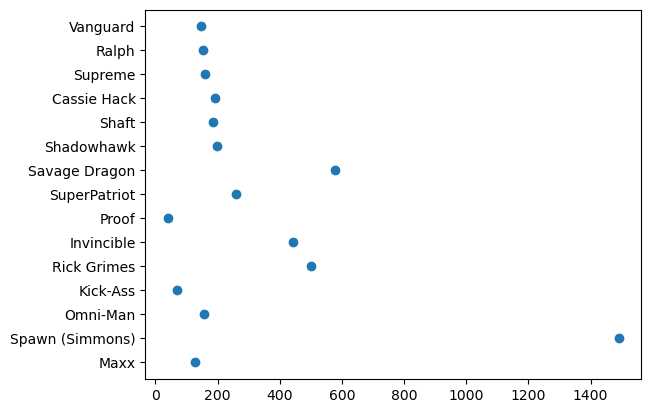

In [37]:
fig3, ax3 = plt.subplots()
ax3.scatter(image_df['count_of_issue_appearances'], image_df['name'])
plt.show()

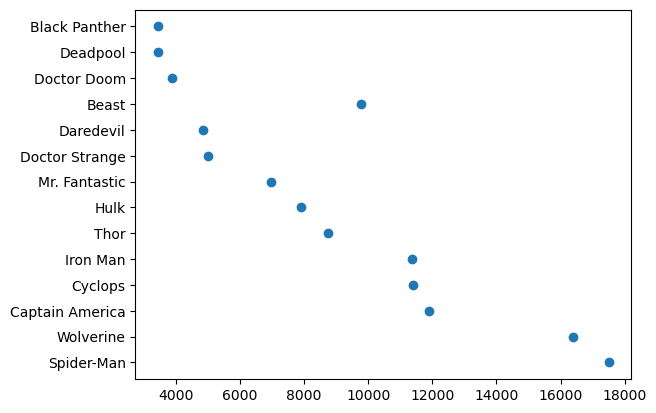

In [38]:
fig4, ax4 = plt.subplots()
ax4.scatter(marvel_df['count_of_issue_appearances'], marvel_df['name'])
plt.show()

I drew these two figures to see if there was a correlation between each superhero and count of issues appeared. This is a useless graph because obviously more popular superheroes are going to get more issues. This was more an excercise to see if the data acquired so far was applicable.

In [39]:
tidy_marvel_df['power_names'].iloc[0]

['Super Strength',
 'Super Speed',
 'Agility',
 'Stamina',
 'Intellect',
 'Healing',
 'Feral',
 'Gadgets',
 'Siphon Abilities',
 'Wall Clinger',
 'Danger Sense',
 'Berserker Strength',
 'Webslinger']

In [40]:
marvel_powers = pd.DataFrame(tidy_marvel_df['power_names'])
image_powers = pd.DataFrame(image_df['power_names'])

This turns the power names from each dataframe into their own dataframes for Marvel and Image Comics respectively

These two graphs below visualize the top 15 powers for each publisher (ChatGPT assisted)

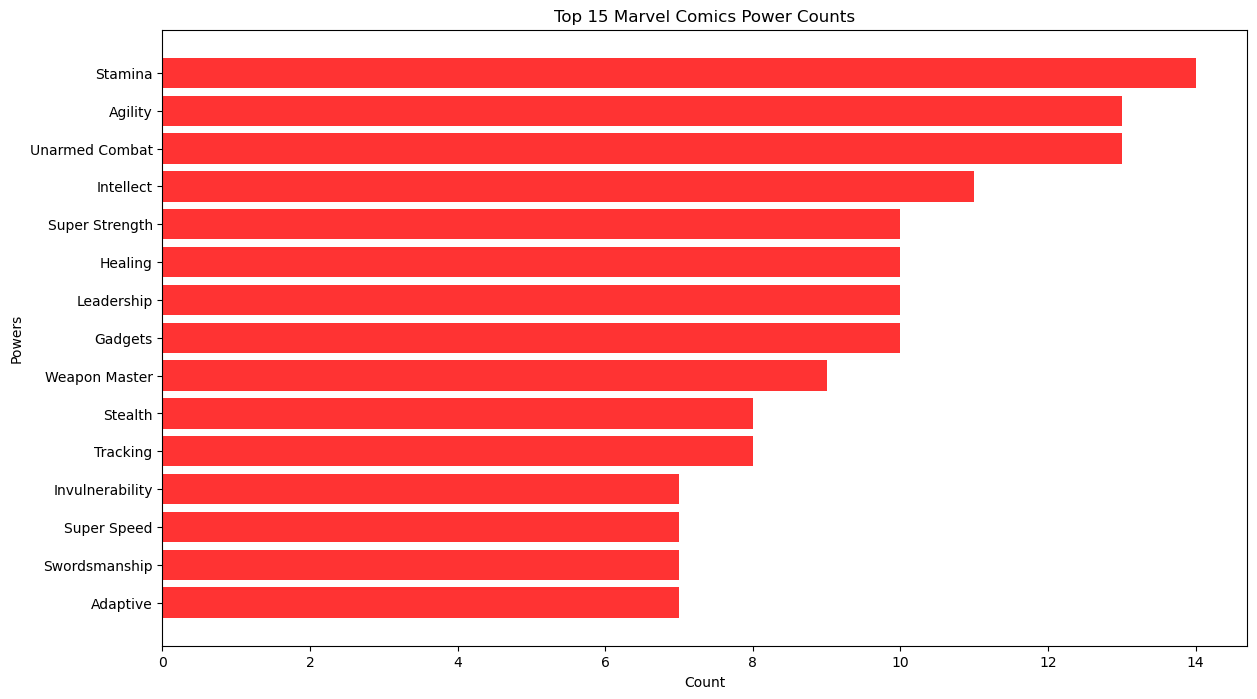

In [41]:
# Step 1: Explode the power_names column to get individual powers
marvel_powers = tidy_marvel_df.explode('power_names')[['power_names']]
marvel_powers = marvel_powers.rename(columns={'power_names': 'Power'})  # Rename for clarity

# Step 2: Count the frequency of each power
mpower_counts = marvel_powers['Power'].value_counts().reset_index()
mpower_counts.columns = ['Power', 'Count']  # Rename columns

# Step 3: Select the top 15 most common powers
mtop_powers = mpower_counts.head(15)

# Step 4: Plot the data
plt.figure(figsize=(14, 8))
plt.barh(mtop_powers['Power'], mtop_powers['Count'], color='red', alpha=0.8)
plt.title("Top 15 Marvel Comics Power Counts")
plt.xlabel("Count")
plt.ylabel("Powers")
plt.gca().invert_yaxis()  # Invert Y-axis for readability
plt.show()

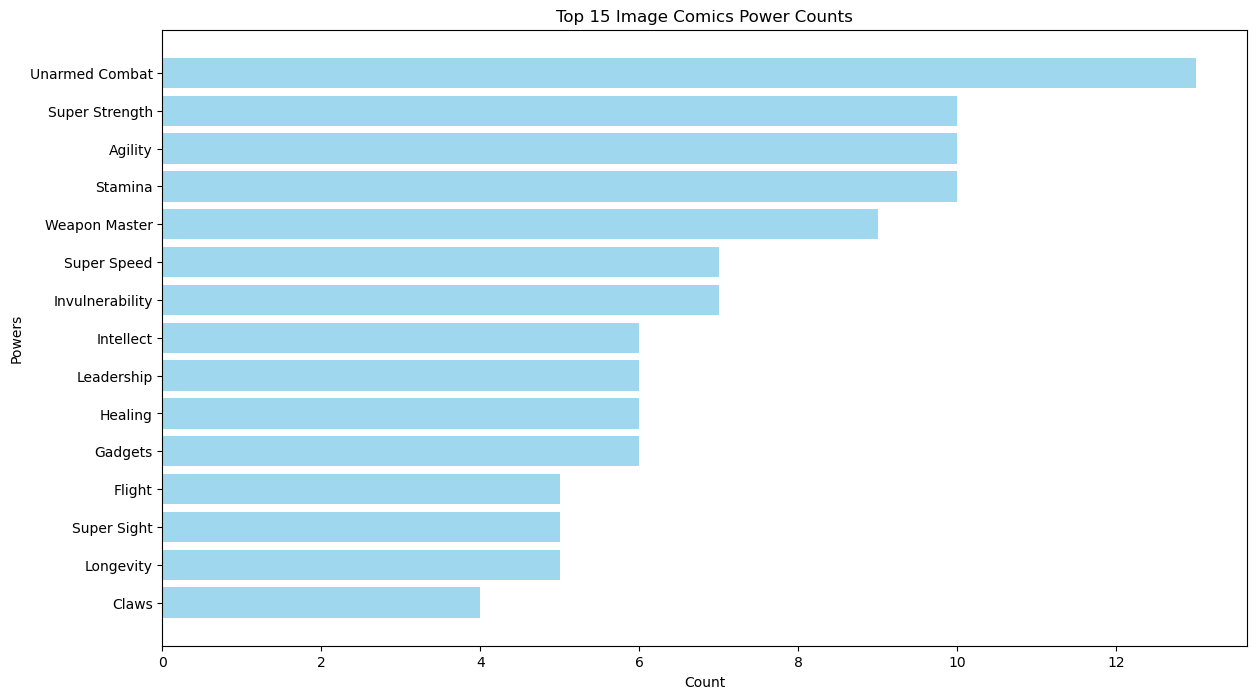

In [42]:
# Step 1: Explode the power_names column to get individual powers
image_powers = image_df.explode('power_names')[['power_names']]
image_powers = image_powers.rename(columns={'power_names': 'Power'})  # Rename for clarity

# Step 2: Count the frequency of each power
ipower_counts = image_powers['Power'].value_counts().reset_index()
ipower_counts.columns = ['Power', 'Count']  # Rename columns

# Step 3: Select the top 15 most common powers
itop_powers = ipower_counts.head(15)

# Step 4: Plot the data
plt.figure(figsize=(14, 8))
plt.barh(itop_powers['Power'], itop_powers['Count'], color='skyblue', alpha=0.8)
plt.title("Top 15 Image Comics Power Counts")
plt.xlabel("Count")
plt.ylabel("Powers")
plt.gca().invert_yaxis()  # Invert Y-axis for readability
plt.show()

In [43]:
merged_df = pd.concat([tidy_marvel_df, image_df], ignore_index=True)
#merged_df.drop(['name','real_name','power_names','gender','id','deck','date_added','date_last_updated','site_detail_url'], axis=1, inplace=True)
merged_df

,name,real_name,power_names,count_of_issue_appearances,gender,id,deck,date_added,date_last_updated,site_detail_url,publisher,publisher_id,publisher_type
0,Spider-Man,Peter Benjamin Parker,"[Super Strength, Super Speed, Agility, Stamina...",17509,1,1443,Peter Parker was bitten by a radioactive spide...,2008-06-06 11:27:11,2024-11-27 04:41:42,https://comicvine.gamespot.com/spider-man/4005...,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
1,Wolverine,James Howlett,"[Super Strength, Agility, Stamina, Invulnerabi...",16399,1,1440,A long-lived mutant with the rage of a beast a...,2008-06-06 11:25:14,2024-10-07 03:58:34,https://comicvine.gamespot.com/wolverine/4005-...,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
2,Captain America,Steven Grant Rogers,"[Super Strength, Agility, Stamina, Intellect, ...",11904,1,1442,"During World War II, Steve Rogers volunteered ...",2008-06-06 11:27:42,2024-12-04 03:43:49,https://comicvine.gamespot.com/captain-america...,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
3,Cyclops,Scott Summers,"[Agility, Stamina, Intellect, Blast Power, Una...",11386,1,1459,"The first X-Man, Scott Summers possesses the m...",2008-06-06 11:27:42,2024-09-26 07:46:13,https://comicvine.gamespot.com/cyclops/4005-1459/,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
4,Iron Man,Anthony Edward Stark,"[Flight, Super Strength, Super Speed, Stamina,...",11363,1,1455,"Tony Stark was the arrogant son of wealthy, we...",2008-06-06 11:27:42,2024-11-27 14:05:03,https://comicvine.gamespot.com/iron-man/4005-1...,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
5,Thor,Thor Odinson,"[Flight, Super Strength, Super Speed, Agility,...",8736,1,2268,Thor Odinson is the All-father of Asgard /God ...,2008-06-06 11:27:42,2024-12-02 16:57:12,https://comicvine.gamespot.com/thor/4005-2268/,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
6,Hulk,Robert Bruce Banner,"[Super Strength, Super Speed, Agility, Stamina...",7893,1,2267,After being bombarded with a massive dose of g...,2008-06-06 11:27:42,2024-12-05 15:59:31,https://comicvine.gamespot.com/hulk/4005-2267/,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
7,Mr. Fantastic,Reed Richards,"[Agility, Stamina, Invulnerability, Intellect,...",6966,1,2151,"Reed Richards, also known as Mr. Fantastic, is...",2008-06-06 11:27:42,2024-10-04 12:17:34,https://comicvine.gamespot.com/mr-fantastic/40...,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
8,Doctor Strange,Stephen Vincent Strange,"[Flight, Agility, Stamina, Telepathy, Telekine...",5014,1,1456,Dr. Stephen Strange was once a gifted but egot...,2008-06-06 11:27:42,2024-11-23 10:04:27,https://comicvine.gamespot.com/doctor-strange/...,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics
9,Daredevil,Matthew Michael Murdock,"[Agility, Stamina, Intellect, Radar Sense, Wea...",4835,1,24694,"As a child, Matt Murdock was blinded by radioa...",2008-06-06 11:27:42,2024-11-20 17:20:09,https://comicvine.gamespot.com/daredevil/4005-...,{'api_detail_url': 'https://comicvine.gamespot...,31,Marvel Comics


this combines both the Image Comics and Marvel Comics dataframes into one

In [44]:
merged_df['Power_Value'] = 1
powers = merged_df[['name', 'power_names', 'Power_Value']].explode('power_names')
powers_df_wide = powers.pivot(index = 'name', columns = 'power_names', values = 'Power_Value').fillna(0)

In [45]:
not_final = pd.merge(powers_df_wide, merged_df, how = 'inner', left_index = True, right_on = 'name')
not_final = not_final.drop(columns = ['publisher', 'publisher_id'])

In [46]:
not_final.groupby('publisher_type').sum()

,Adaptive,Agility,Animal Control,Animation,Astral Projection,Berserker Strength,Blast Power,Chameleon,Chemical Absorbtion,Claws,...,real_name,power_names,count_of_issue_appearances,gender,id,deck,date_added,date_last_updated,site_detail_url,Power_Value
publisher_type,,,,,,,,,,,,,,,,,,,,,
Image Comics,3.0,10.0,0.0,2.0,0.0,3.0,2.0,1.0,1.0,4.0,...,Cassandra HackMarkus Sebastian GraysonDavid Li...,"[Agility, Stamina, Weapon Master, Unarmed Comb...",4700,16,387108,Cassie Hack is the lone survivor of an attack ...,2008-06-06 11:27:202008-06-06 11:27:372008-06-...,2024-05-18 13:47:522024-03-02 06:00:282019-05-...,https://comicvine.gamespot.com/cassie-hack/400...,15
Marvel Comics,7.0,13.0,1.0,2.0,3.0,6.0,6.0,1.0,1.0,4.0,...,Henry Philip McCoyT'ChallaSteven Grant RogersS...,"[Super Strength, Super Speed, Agility, Stamina...",122571,14,52088,"A founding member of the X-Men, Dr. Hank McCoy...",2008-06-06 11:27:422008-06-06 11:27:422008-06-...,2024-12-04 14:59:482024-10-04 09:42:212024-12-...,https://comicvine.gamespot.com/beast/4005-1462...,14


From here, with Prof. Silva's help of course, I was able to structure the Dataframe by publisher_type and power_names. Next I assigned 1's to the power_name column if the hero in question has that power; 1's being yes and 0's being no. From there I grouped by publisher and should soon be able to make a scatter plot with count_of_issue_appearances on the y axis and powers (as their 1's and 0's) on the x axis. From this point, i am pivoting my goal to see how often each power shows up in each comic publisher.

In [47]:
#shows what each publisher issue value is
not_final_exploded = not_final.explode('publisher_type')

#sort by most issues first
publisher_counts = not_final_exploded.sort_values('count_of_issue_appearances', ascending=False)

publisher_counts

,Adaptive,Agility,Animal Control,Animation,Astral Projection,Berserker Strength,Blast Power,Chameleon,Chemical Absorbtion,Claws,...,power_names,count_of_issue_appearances,gender,id,deck,date_added,date_last_updated,site_detail_url,publisher_type,Power_Value
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,"[Super Strength, Super Speed, Agility, Stamina...",17509,1,1443,Peter Parker was bitten by a radioactive spide...,2008-06-06 11:27:11,2024-11-27 04:41:42,https://comicvine.gamespot.com/spider-man/4005...,Marvel Comics,1
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,"[Super Strength, Agility, Stamina, Invulnerabi...",16399,1,1440,A long-lived mutant with the rage of a beast a...,2008-06-06 11:25:14,2024-10-07 03:58:34,https://comicvine.gamespot.com/wolverine/4005-...,Marvel Comics,1
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"[Super Strength, Agility, Stamina, Intellect, ...",11904,1,1442,"During World War II, Steve Rogers volunteered ...",2008-06-06 11:27:42,2024-12-04 03:43:49,https://comicvine.gamespot.com/captain-america...,Marvel Comics,1
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,"[Agility, Stamina, Intellect, Blast Power, Una...",11386,1,1459,"The first X-Man, Scott Summers possesses the m...",2008-06-06 11:27:42,2024-09-26 07:46:13,https://comicvine.gamespot.com/cyclops/4005-1459/,Marvel Comics,1
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,"[Flight, Super Strength, Super Speed, Stamina,...",11363,1,1455,"Tony Stark was the arrogant son of wealthy, we...",2008-06-06 11:27:42,2024-11-27 14:05:03,https://comicvine.gamespot.com/iron-man/4005-1...,Marvel Comics,1
10,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,"[Super Strength, Super Speed, Agility, Stamina...",9781,1,1462,"A founding member of the X-Men, Dr. Hank McCoy...",2008-06-06 11:27:42,2024-12-04 14:59:48,https://comicvine.gamespot.com/beast/4005-1462/,Marvel Comics,1
5,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,"[Flight, Super Strength, Super Speed, Agility,...",8736,1,2268,Thor Odinson is the All-father of Asgard /God ...,2008-06-06 11:27:42,2024-12-02 16:57:12,https://comicvine.gamespot.com/thor/4005-2268/,Marvel Comics,1
6,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,"[Super Strength, Super Speed, Agility, Stamina...",7893,1,2267,After being bombarded with a massive dose of g...,2008-06-06 11:27:42,2024-12-05 15:59:31,https://comicvine.gamespot.com/hulk/4005-2267/,Marvel Comics,1
7,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,"[Agility, Stamina, Invulnerability, Intellect,...",6966,1,2151,"Reed Richards, also known as Mr. Fantastic, is...",2008-06-06 11:27:42,2024-10-04 12:17:34,https://comicvine.gamespot.com/mr-fantastic/40...,Marvel Comics,1
8,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,"[Flight, Agility, Stamina, Telepathy, Telekine...",5014,1,1456,Dr. Stephen Strange was once a gifted but egot...,2008-06-06 11:27:42,2024-11-23 10:04:27,https://comicvine.gamespot.com/doctor-strange/...,Marvel Comics,1


this dataframe explodes publisher_types from the last dataframe and sorts it by count_of_issue_appearances

In [67]:
power_columns = [col for col in not_final_exploded.columns if col not in ['publisher_type', 'count_of_issue_appearances', 'real_name', 'power_names', 'deck', 'date_added', 'date_last_updated','site_detail_url','name','gender','id', 'Power_Value']]

power_sums = pd.DataFrame(not_final_exploded[power_columns].sum())
power_sums.index

Index(['Adaptive', 'Agility', 'Animal Control', 'Animation',
       'Astral Projection', 'Berserker Strength', 'Blast Power', 'Chameleon',
       'Chemical Absorbtion', 'Claws',
       ...
       'Vampirism', 'Vibration Wave', 'Voice-induced Manipulation',
       'Wall Clinger', 'Water Control', 'Weapon Master', 'Weather Control',
       'Webslinger', 'Willpower-Based Constructs', 'Wind Bursts'],
      dtype='object', length=110)

power_columns isolates just the different power names and their values in order to put them into a dataframe called power_sums

In [68]:
power_sums


,0
Adaptive,10.0
Agility,23.0
Animal Control,1.0
Animation,4.0
Astral Projection,3.0
...,...
Weapon Master,18.0
Weather Control,1.0
Webslinger,1.0
Willpower-Based Constructs,3.0


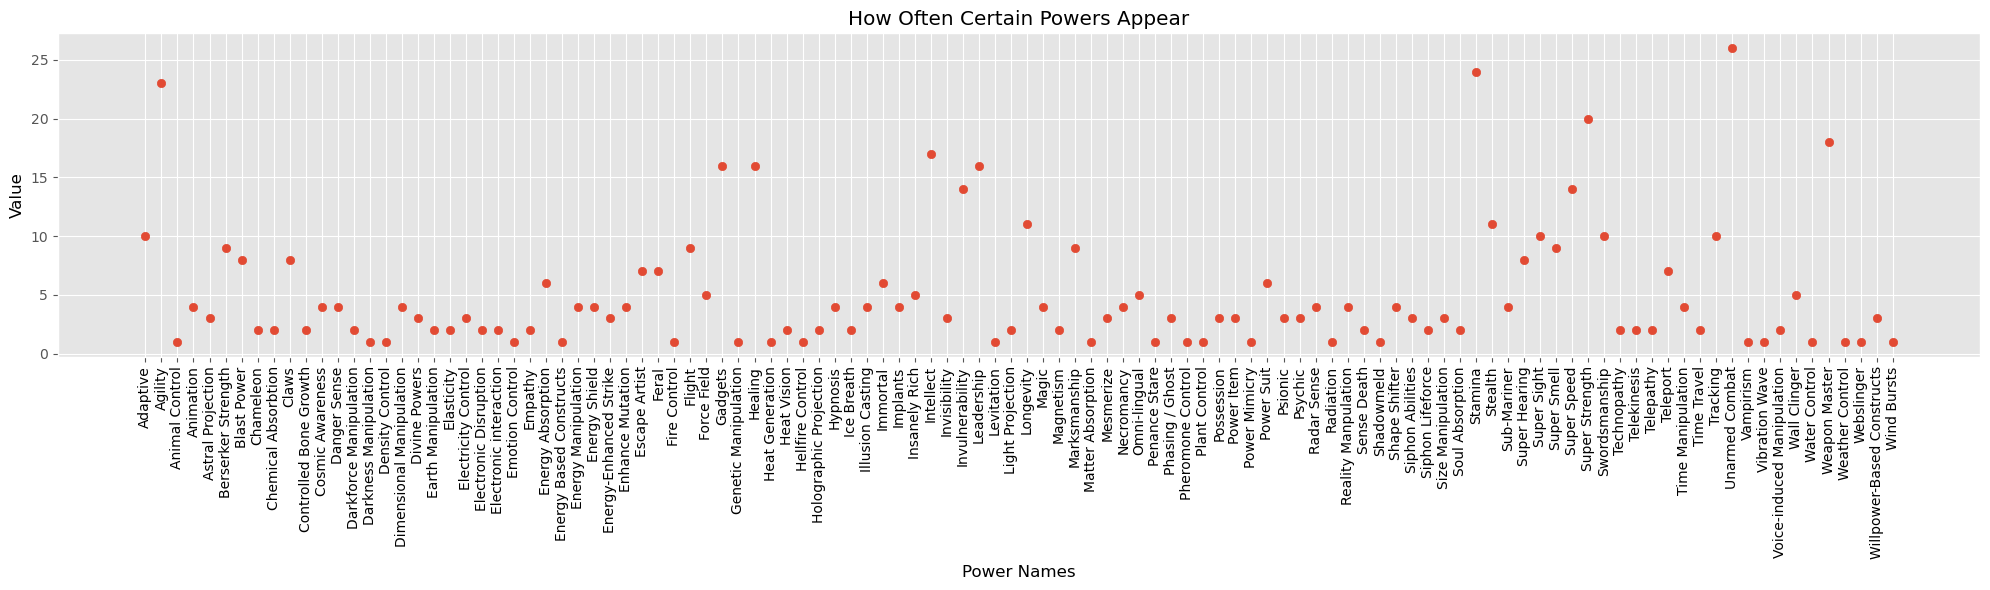

In [70]:
fig5, ax5 = plt.subplots(figsize = (20,6))
ax5.scatter(power_sums.index, power_sums[0])
ax5.set_title('How Often Certain Powers Appear')
ax5.set_xlabel('Power Names', color = 'black')
ax5.set_ylabel('Value', color = 'black')
#ax5.legend(publisher_counts['publisher_type'], publisher_counts['publisher_type'])
plt.style.use('ggplot')
plt.xticks(rotation=90, color='black')
plt.tight_layout()
plt.show()

using power_sums I was able to create a graph that shows the frequency of each power in marvel and image comics. The next thing I need to do is differentiate Marvel and Image Comics from each other.

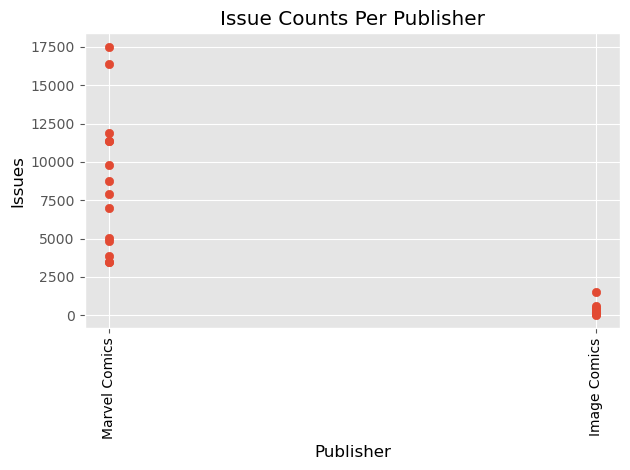

In [66]:
fig5, ax5 = plt.subplots()
ax5.scatter(not_final['publisher_type'], not_final['count_of_issue_appearances'])
ax5.set_title('Issue Counts Per Publisher')
ax5.set_xlabel('Publisher', color = 'black')
ax5.set_ylabel('Issues', color = 'black')
#ax5.legend(publisher_counts['publisher_type'].iloc[0], publisher_counts['publisher_type'].iloc[1])
plt.style.use('ggplot')
plt.xticks(rotation=90, color='black')
plt.tight_layout()
plt.show()

this scatter plot shows us the issue counts by publisher. I created this plot to see if I was able to use the publisher_type header from the not_final dataframe.

In [79]:
power_sums = pd.DataFrame(not_final.groupby(['publisher_type']).sum().reset_index())


power_sums.head()

,publisher_type,Adaptive,Agility,Animal Control,Animation,Astral Projection,Berserker Strength,Blast Power,Chameleon,Chemical Absorbtion,...,real_name,power_names,count_of_issue_appearances,gender,id,deck,date_added,date_last_updated,site_detail_url,Power_Value
0,Image Comics,3.0,10.0,0.0,2.0,0.0,3.0,2.0,1.0,1.0,...,Cassandra HackMarkus Sebastian GraysonDavid Li...,"[Agility, Stamina, Weapon Master, Unarmed Comb...",4700,16,387108,Cassie Hack is the lone survivor of an attack ...,2008-06-06 11:27:202008-06-06 11:27:372008-06-...,2024-05-18 13:47:522024-03-02 06:00:282019-05-...,https://comicvine.gamespot.com/cassie-hack/400...,15
1,Marvel Comics,7.0,13.0,1.0,2.0,3.0,6.0,6.0,1.0,1.0,...,Henry Philip McCoyT'ChallaSteven Grant RogersS...,"[Super Strength, Super Speed, Agility, Stamina...",122571,14,52088,"A founding member of the X-Men, Dr. Hank McCoy...",2008-06-06 11:27:422008-06-06 11:27:422008-06-...,2024-12-04 14:59:482024-10-04 09:42:212024-12-...,https://comicvine.gamespot.com/beast/4005-1462...,14


In [76]:
# Ensure 'publisher_type' is treated as a string
not_final['publisher_type'] = not_final['publisher_type'].astype(str)

chatGPT assisted for the above two lines

In [80]:
marvel_powers = power_sums[power_sums['publisher_type'] == 'Marvel Comics']
image_powers = power_sums[power_sums['publisher_type'] == 'Image Comics']

In [81]:
marvel_powers = marvel_powers.drop(columns = ['real_name','name','deck',   'power_names', 'count_of_issue_appearances', 'gender',  'id','date_added','date_last_updated','site_detail_url'])     

In [82]:
image_powers = image_powers.drop(columns = ['real_name','name','deck',   'power_names', 'count_of_issue_appearances', 'gender',  'id','date_added','date_last_updated','site_detail_url'])     

In [83]:
marvel_powers

,publisher_type,Adaptive,Agility,Animal Control,Animation,Astral Projection,Berserker Strength,Blast Power,Chameleon,Chemical Absorbtion,...,Vibration Wave,Voice-induced Manipulation,Wall Clinger,Water Control,Weapon Master,Weather Control,Webslinger,Willpower-Based Constructs,Wind Bursts,Power_Value
1,Marvel Comics,7.0,13.0,1.0,2.0,3.0,6.0,6.0,1.0,1.0,...,1.0,1.0,4.0,1.0,9.0,1.0,1.0,1.0,1.0,14


In [84]:
image_powers

,publisher_type,Adaptive,Agility,Animal Control,Animation,Astral Projection,Berserker Strength,Blast Power,Chameleon,Chemical Absorbtion,...,Vibration Wave,Voice-induced Manipulation,Wall Clinger,Water Control,Weapon Master,Weather Control,Webslinger,Willpower-Based Constructs,Wind Bursts,Power_Value
0,Image Comics,3.0,10.0,0.0,2.0,0.0,3.0,2.0,1.0,1.0,...,0.0,1.0,1.0,0.0,9.0,0.0,0.0,2.0,0.0,15


I was able to create two simplied dataframes containing the publisher type (Marvel and Image Comics) and the powers along with their values for each publisher. I should be able to plot this now because the publisher_type is now being treated as a string

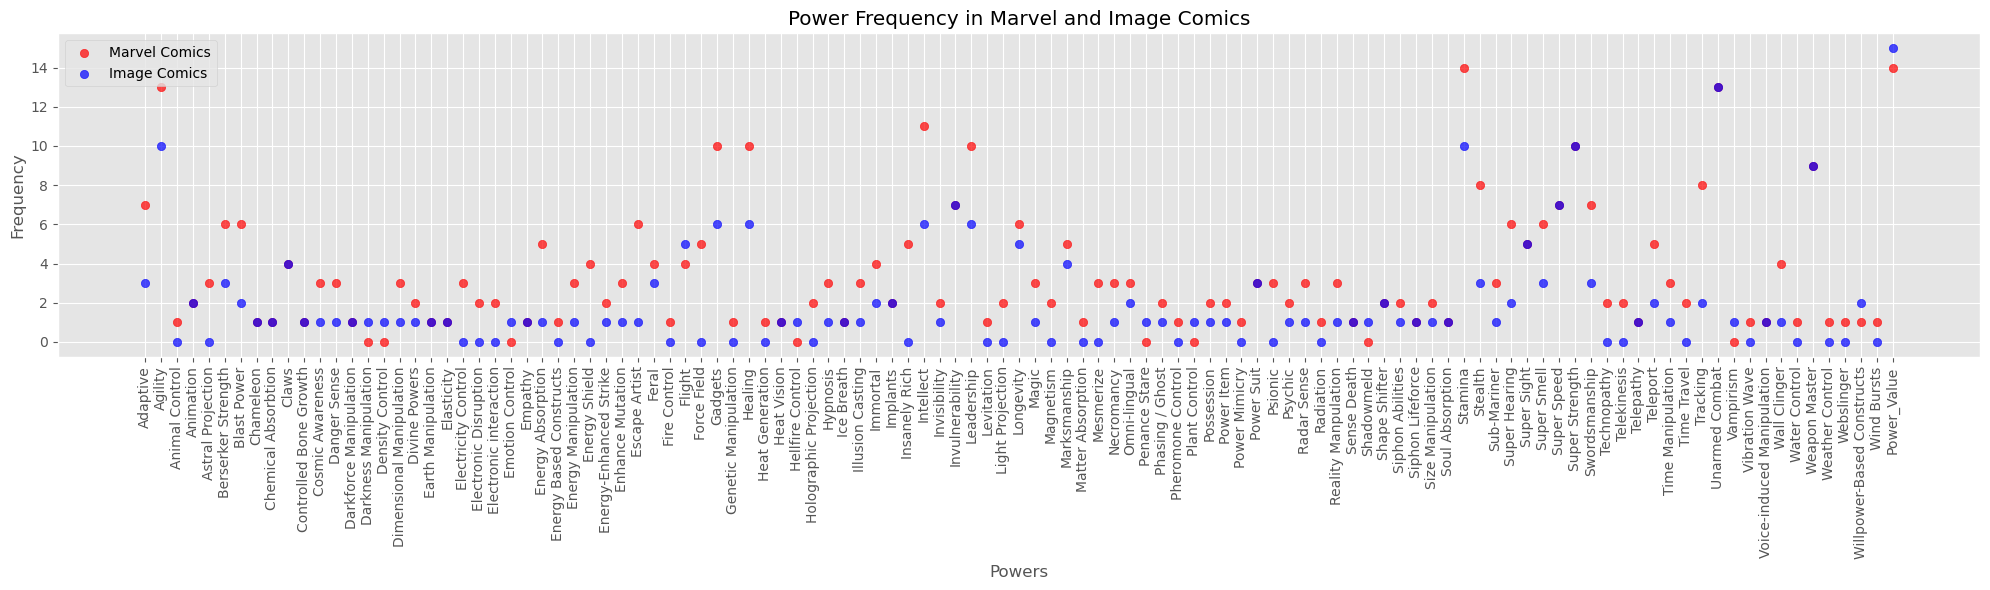

In [89]:

# isolating only the powers by dropping the publisher_type column
marvel_powers_data = marvel_powers.drop(columns=['publisher_type'])
image_powers_data = image_powers.drop(columns=['publisher_type'])

# sums up each value for each power in each dataframe
marvel_sums = marvel_powers_data.sum(axis=0)
image_sums = image_powers_data.sum(axis=0)

# Power names for x-axis
powers = marvel_sums.index


fig6, ax6 = plt.subplots(figsize=(20, 6))
ax6.scatter(powers, marvel_sums, color='red', label='Marvel Comics', alpha=0.7)
ax6.scatter(powers, image_sums, color='blue', label='Image Comics', alpha=0.7)
ax6.set_title('Power Frequency in Marvel and Image Comics')
ax6.set_xlabel('Powers')
ax6.set_ylabel('Frequency')
ax6.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.style.use('ggplot')
plt.show()


From this visualization we can tell that from the characters I chose for each publisher (top 15 of each publisher), Marvel and Image Comics overall have a large overlap whe it comes to powers. Marvel tends to use the same powers more often as we can tell with powers like gadgets, healing, and stamina. From this we can assume that Marvel tends to use a lot of the same powers for this group of heroes. Image Comics on the other hand, has a lot of powers that tend to be assigned to only one or two characters, making their characters more distinct when it comes to their powers.

I had to pivot again from my idea of using count_of_issue_appearances, as it was out of my abillity range to use all that data effectively. Although I pivoted a few times from my original hypothesis, I am so glad that I was able to visualize this. While I wasn't able to work with my original two hypotheses, I was able to use the data I had already gathered to change my perspective and look at the data differently and prove my new hypothesis.